# Importing the Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
import numpy as np
import matplotlib.pyplot as plt

# Data Generation

## Defining the function

In [2]:
def generate_data(batch_size, seq_length):
    messages = np.random.choice([-1, 1], size=(batch_size, seq_length, 1)).astype(np.float32)
    keys = np.random.choice([-1, 1], size=(batch_size, seq_length, 1)).astype(np.float32)
    return messages, keys

## Parameters for Data Generation

In [3]:
batch_size = 64
seq_length = 256
train_size = 1000
test_size = 200

## Generating training and testing data

In [4]:
train_messages, train_keys = generate_data(train_size, seq_length)
test_messages, test_keys = generate_data(test_size, seq_length)

# Defining the Neural Networks

## Alice's Neural Network

In [5]:
def build_encryption_net():
    model = models.Sequential()
    model.add(layers.Conv1D(seq_length, 3, padding='same', input_shape=(None, 2)))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))
    return model

## Bob's Neural Network

In [6]:
def build_decryption_net():
    model = models.Sequential()
    model.add(layers.Conv1D(seq_length, 3, padding='same', input_shape=(None, 2)))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))
    return model

## Eve's Neural Network

In [7]:
def build_adversary_net():
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(seq_length, 1)))
    model.add(layers.Dense(seq_length, activation='relu'))
    model.add(layers.Dense(seq_length*2, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

## Loss Functions

In [8]:
def separation(alice_input, bob_output):
    separation_value = tf.reduce_sum(tf.abs(tf.subtract(alice_input, bob_output)), axis=1)
    # print("separation", separation_value.numpy())
    return separation_value

def eve_vs_random_guess(alice_input, eve_output):
    loss = tf.square(seq_length/2 - separation(alice_input, eve_output)) / (seq_length/2) ** 2
    # print("Eve vs random guess loss:", loss.numpy())
    return tf.reduce_mean(loss)

def combined_loss_function(alice_input, decipher_bob, eve_output):
    loss = separation(alice_input, decipher_bob)/seq_length + eve_vs_random_guess(alice_input, eve_output)
    # print("Combined loss function:", loss.numpy())
    return tf.reduce_mean(loss)

def attacker_loss(alice_input, eve_output):
    loss = separation(alice_input, eve_output)
    # print("Attacker loss:", loss.numpy())
    return tf.reduce_mean(loss)

## Instantiating and compiling the Neural Networks

In [9]:
alice = build_encryption_net()
bob = build_decryption_net()
eve = build_adversary_net()

In [10]:
optimizer_ab = optimizers.Adam(learning_rate=0.0008)
optimizer_e = optimizers.Adam(learning_rate=0.0008)

## Training and Testing

In [11]:
num_epochs = 250

train_losses_ab_list = []
train_losses_e_list = []
test_losses_ab_list = []
test_losses_e_list = []

for epoch in range(num_epochs):
    with tf.GradientTape() as tape_ab:
        combined_input = tf.concat([train_messages, train_keys], axis=-1)
        ciphertext = alice(combined_input)

        decrypted_input = tf.concat([ciphertext, train_keys], axis=-1)
        decrypted_messages = bob(decrypted_input)

        loss_ab = combined_loss_function(train_messages, decrypted_messages, eve(ciphertext))

    gradients_ab = tape_ab.gradient(loss_ab, alice.trainable_variables + bob.trainable_variables)
    optimizer_ab.apply_gradients(zip(gradients_ab, alice.trainable_variables + bob.trainable_variables))

    with tf.GradientTape() as tape_e:
        guessed_messages = eve(ciphertext)
        loss_e = attacker_loss(train_messages, guessed_messages)  # L1 loss for Eve

    gradients_e = tape_e.gradient(loss_e, eve.trainable_variables)
    optimizer_e.apply_gradients(zip(gradients_e, eve.trainable_variables))

    train_losses_ab_list.append(loss_ab.numpy())
    train_losses_e_list.append(loss_e.numpy())

    test_ciphertext = alice(tf.concat([test_messages, test_keys], axis=-1))
    test_decrypted_messages = bob(tf.concat([test_ciphertext, test_keys], axis=-1))
    test_guessed_messages = eve(test_ciphertext)

    test_loss_ab = combined_loss_function(test_messages, test_decrypted_messages, test_guessed_messages)
    test_loss_e = attacker_loss(test_messages, test_guessed_messages)

    test_losses_ab_list.append(test_loss_ab.numpy())
    test_losses_e_list.append(test_loss_e.numpy())

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss_AB: {loss_ab.numpy()}, Train Loss_E: {loss_e.numpy()}, "
          f"Test Loss_AB: {test_loss_ab.numpy()}, Test Loss_E: {test_loss_e.numpy()}")

Epoch 1/250, Train Loss_AB: 1.9963306188583374, Train Loss_E: 255.61367797851562, Test Loss_AB: 2.024757146835327, Test Loss_E: 257.0577392578125
Epoch 2/250, Train Loss_AB: 1.9960376024246216, Train Loss_E: 255.5809326171875, Test Loss_AB: 2.0249602794647217, Test Loss_E: 257.0473327636719
Epoch 3/250, Train Loss_AB: 1.995358943939209, Train Loss_E: 255.52505493164062, Test Loss_AB: 2.024695873260498, Test Loss_E: 257.00823974609375
Epoch 4/250, Train Loss_AB: 1.9942617416381836, Train Loss_E: 255.44381713867188, Test Loss_AB: 2.023953914642334, Test Loss_E: 256.93890380859375
Epoch 5/250, Train Loss_AB: 1.9927130937576294, Train Loss_E: 255.33486938476562, Test Loss_AB: 2.0226752758026123, Test Loss_E: 256.8362121582031
Epoch 6/250, Train Loss_AB: 1.9906704425811768, Train Loss_E: 255.1964111328125, Test Loss_AB: 2.0209062099456787, Test Loss_E: 256.70233154296875
Epoch 7/250, Train Loss_AB: 1.988147497177124, Train Loss_E: 255.028076171875, Test Loss_AB: 2.0184569358825684, Test Los

# Plotting

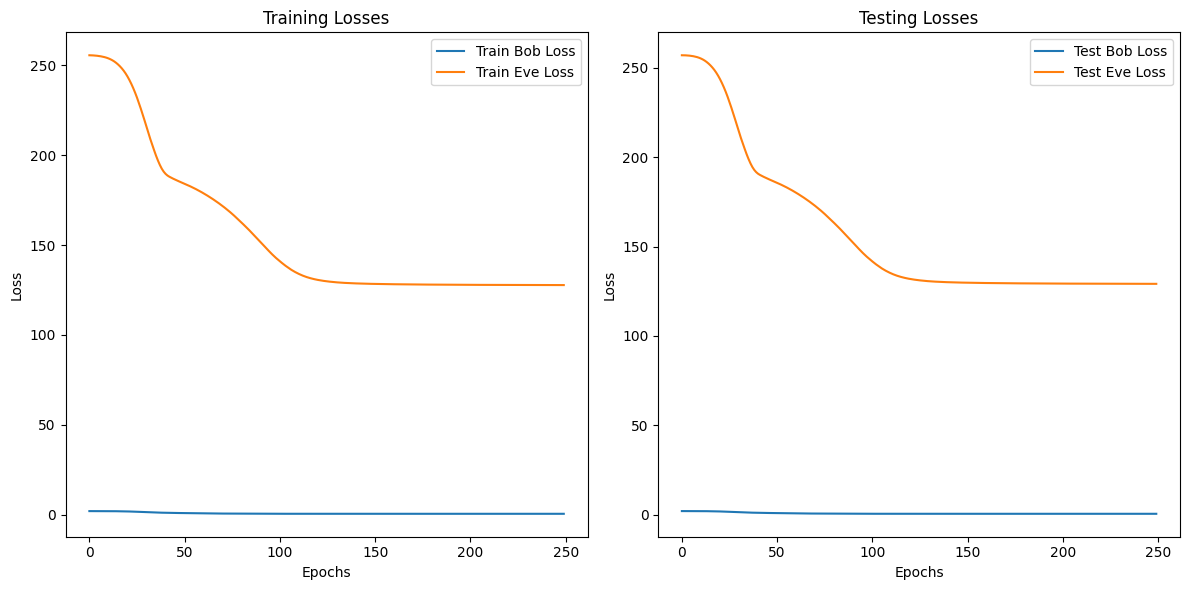

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses_ab_list, label='Train Bob Loss')
plt.plot(train_losses_e_list, label='Train Eve Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_losses_ab_list, label='Test Bob Loss')
plt.plot(test_losses_e_list, label='Test Eve Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Testing Losses')
plt.legend()

plt.tight_layout()
plt.show()